In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import seaborn as sns
#from seaborn import plt (alternate)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import RegressionResults
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/aglee/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read scraped data
print("MLS Listings Data in the Past 3 Years - as of Oct 8th, 2018")
sold_sf = pd.read_pickle('data/mlssold_sf_20181008.pkl')
sold_south = pd.read_pickle('data/mlssold_south_20181008_part1.pkl').append(pd.read_pickle('data/mlssold_south_20181008_part2.pkl')).append(pd.read_pickle('data/mlssold_south_20181008_part3.pkl')).append(pd.read_pickle('data/mlssold_south_20181008_part4.pkl')).append(pd.read_pickle('data/mlssold_south_20181008_part5.pkl'))
sold_east = pd.read_pickle('data/mlssold_east_20181008_part1.pkl').append(pd.read_pickle('data/mlssold_east_20181008_part2.pkl')).append(pd.read_pickle('data/mlssold_east_20181008_part3.pkl')).append(pd.read_pickle('data/mlssold_east_20181008_part4.pkl')).append(pd.read_pickle('data/mlssold_east_20181008_part5.pkl')).append(pd.read_pickle('data/mlssold_east_20181008_part6.pkl'))
sold_sm = pd.read_pickle('data/mlssold_sm_20181008_part1.pkl').append(pd.read_pickle('data/mlssold_sm_20181008_part2.pkl'))
print("-Number of Houses Sold in San Francisco:",sold_sf.shape[0])
print("-Number of Houses Sold in Alameda County:",sold_south.shape[0])
print("-Number of Houses Sold in Santa Clara County:",sold_east.shape[0])
print("-Number of Houses Sold in San Mateo County:",sold_sm.shape[0])

MLS Listings Data in the Past 3 Years - as of Oct 8th, 2018
-Number of Houses Sold in San Francisco: 802
-Number of Houses Sold in Alameda County: 41169
-Number of Houses Sold in Santa Clara County: 41786
-Number of Houses Sold in San Mateo County: 16441


In [3]:
# Read school district directory file (Source: California's Department of Education)
df_district = pd.read_csv('data/baydistricts.csv', sep=',', encoding='utf-8', header=0, dtype={'Zip': object,'Plus4': object})

In [4]:
# Combine into one dataframe
sold_sf['County'] = 'San Francisco County'
sold_south['County'] = 'Santa Clara County'
sold_east['County'] = 'Alameda County'
sold_sm['County'] = 'San Mateo County'
X_raw = sold_sf.append(sold_south).append(sold_east).append(sold_sm)

In [5]:
# Examine the raw data
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_columns',1000)
print("Number of Data Points:",X_raw.shape[0])

Number of Data Points: 100198


In [6]:
# Remove duplicates
X_raw['is_duplicate']= X_raw.duplicated(['MLS_Number','Sold_Date'])
X_adj = X_raw[X_raw.is_duplicate==False]
print("Number of Data Points:",X_adj.shape[0])
del X_raw

Number of Data Points: 100185


In [7]:
# Continuous variables: convert relevant columns into numerical data types
X_adj['Prices'] = X_adj['Prices'].apply(lambda x: float(x))
X_adj['Sq_Ft'] = X_adj['Sq_Ft'].apply(lambda x: float(x.replace(",","")) if x!='–' else float(0))
X_adj['Lot_Size'] = X_adj['Lot_Size'].apply(lambda x: float(x.replace(",","")) if x!='–' else float(0))
X_adj['Years_Since_Built'] = X_adj['Built'].apply(lambda x: float(2018)-float(x))
X_adj['Days_On_Site'] = X_adj['Status'].apply(lambda x: float(x.replace(",","")) if x!='–' else float(0))
X_adj['HOA'] = X_adj['HOA'].apply(lambda x: float(x.replace("$","").replace(",","")) if x!='–' else float(0))

In [8]:
# Create New Columns City and Zip Codes
X_adj['City'] = X_adj['Address'].apply(lambda x: x.split(',')[-2].strip())
X_adj['Zip'] = X_adj['Address'].apply(lambda x: x.split(',')[-1].replace('CA ','').replace('– ','').strip() if x.find('-')<1 else x.split(',')[-1].split('-')[0].replace('CA ','').strip())

In [9]:
# Helper function for data cleanup
def district_helper(x,y):
    if y == '–':
        return x
    else:
        return y

def city_helper(x,y):
    if y=='–' and x == '95076':
        return 'Watsonville'
    elif y=='–' and x == '95046':
        return 'San Martin'
    elif y=='–' and x == '95023':
        return 'Hollister'
    elif y=='–' and x == '94018':
        return 'El Granada'
    elif y=='–' and x == '94303':
        return 'Palo Alto'
    else:
        return y

In [10]:
# Fix mislabeled cities
X_adj['City'] = X_adj.apply(lambda row: city_helper(row['Zip'],row['City']), axis=1)

In [11]:
# Create new district column (for Elementary Schools)
X_adj = X_adj.merge(df_district, how='left',on=['City','Zip'])
X_adj['School_District'] = X_adj['ES_District']
X_adj['School_District'] = X_adj.apply(lambda row: "%s - %s" % ('District', district_helper(row['District'],row['School_District'])), axis=1)
X_adj['School_District'] = X_adj['School_District'].apply(lambda x: x.replace(' ','').replace('-','_').replace('.','').strip())
X_adj.groupby(['County_x']).agg({'School_District':['nunique']})

,School_District
,nunique
County_x,
Alameda County,21
San Francisco County,4
San Mateo County,27
Santa Clara County,35


In [12]:
# Categorical variable: format columns to create dummy variables
X_adj['Property_Type'] = X_adj['Property_Type'].apply(lambda x: x.replace(' ','').strip())
X_adj['Beds'] = X_adj['Bedrooms'].apply(lambda x: 'Bedrooms_'+x)
X_adj['Fireplace_b'] = X_adj['Fireplace'].apply(lambda x: 1 if x!='–' else 0)
X_adj['Pool_b'] = X_adj['Pool'].apply(lambda x: 1 if x!='–' else 0)
X_adj['Garage_Count'] = X_adj['Garage'].apply(lambda x: 'Cars_'+x.split(',')[-1].split(' ')[-2].strip() if x!='–' else 'Cars_0')
X_adj['Full_Bath'] = X_adj['Bathrooms'].apply(lambda x: 'Full_Baths_'+x.split('/')[0].strip())
X_adj['Part_Bath'] = X_adj['Bathrooms'].apply(lambda x: 'Part_Baths_'+x.split('/')[1].strip() if x.find('/')==1 else 'Part_Baths_0')

In [13]:
# Create dummy variables for Property Type
data_ = X_adj['Property_Type'].value_counts()

list_ = [[i] for i in list(X_adj['Property_Type'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("Type:", one_hot.classes_)
type_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",type_df.shape)

Type: ['Condominium' 'SingleFamilyResidence' 'Townhouse']
Shape is: (100185, 3)


In [14]:
# Create dummy variables for Number of Bedrooms
data_ = X_adj['Beds'].value_counts()

list_ = [[i] for i in list(X_adj['Beds'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("Bedrooms:", one_hot.classes_)
beds_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",beds_df.shape)

Bedrooms: ['Bedrooms_0' 'Bedrooms_1' 'Bedrooms_10' 'Bedrooms_12' 'Bedrooms_14'
 'Bedrooms_2' 'Bedrooms_20' 'Bedrooms_21' 'Bedrooms_24' 'Bedrooms_3'
 'Bedrooms_4' 'Bedrooms_5' 'Bedrooms_6' 'Bedrooms_7' 'Bedrooms_8'
 'Bedrooms_9']
Shape is: (100185, 16)


In [15]:
# Create dummy variables for Number of Cars (Garage Size)
data_ = X_adj['Garage_Count'].value_counts()

list_ = [[i] for i in list(X_adj['Garage_Count'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("Garage_Count:", one_hot.classes_)
garg_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",garg_df.shape)

Garage_Count: ['Cars_' 'Cars_0' 'Cars_1' 'Cars_10' 'Cars_100' 'Cars_11' 'Cars_12'
 'Cars_127' 'Cars_13' 'Cars_131' 'Cars_132' 'Cars_15' 'Cars_16' 'Cars_17'
 'Cars_18' 'Cars_191' 'Cars_2' 'Cars_20' 'Cars_200' 'Cars_23' 'Cars_246'
 'Cars_25' 'Cars_26' 'Cars_3' 'Cars_35' 'Cars_37' 'Cars_4' 'Cars_40'
 'Cars_42' 'Cars_5' 'Cars_6' 'Cars_66' 'Cars_7' 'Cars_8' 'Cars_9']
Shape is: (100185, 35)


In [16]:
# Create dummy variables for Number of Full-sized Bathrooms
data_ = X_adj['Full_Bath'].value_counts()

list_ = [[i] for i in list(X_adj['Full_Bath'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("Full_Bath:", one_hot.classes_)
fbat_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",fbat_df.shape)

Full_Bath: ['Full_Baths_0' 'Full_Baths_1' 'Full_Baths_12' 'Full_Baths_2'
 'Full_Baths_3' 'Full_Baths_4' 'Full_Baths_5' 'Full_Baths_6'
 'Full_Baths_7' 'Full_Baths_8' 'Full_Baths_9']
Shape is: (100185, 11)


In [17]:
# Create dummy variables for Number of Partial-sized Bathrooms
data_ = X_adj['Part_Bath'].value_counts()

list_ = [[i] for i in list(X_adj['Part_Bath'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("Part_Bath:", one_hot.classes_)
pfat_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",pfat_df.shape)

Part_Bath: ['Part_Baths_0' 'Part_Baths_1' 'Part_Baths_11' 'Part_Baths_12'
 'Part_Baths_2' 'Part_Baths_25' 'Part_Baths_3' 'Part_Baths_4'
 'Part_Baths_5' 'Part_Baths_8']
Shape is: (100185, 10)


In [18]:
# Create dummy variables for School Districts
data_ = X_adj['School_District'].value_counts()

list_ = [[i] for i in list(X_adj['School_District'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("School_District:", one_hot.classes_)
sdst_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",sdst_df.shape)

School_District: ['District_AlamedaCityUnified' 'District_AlamedaUnified'
 'District_AlbanyCityUnified' 'District_AlumRockUnionElementary'
 'District_BayshoreElementary' 'District_Belmont_RedwoodShoresElementary'
 'District_BerkeleyUnified' 'District_BerryessaUnionElementary'
 'District_BrisbaneElementary' 'District_BurlingameElementary'
 'District_CabrilloUnified' 'District_CambrianElementary'
 'District_CampbellUnion' 'District_CampbellUnionElementary'
 'District_CastroValleyUnified' 'District_CupertinoUnion'
 'District_DublinUnified' 'District_EastSideUnionHigh'
 'District_EmeryUnified' 'District_EvergreenElementary'
 'District_Franklin_McKinleyElementary' 'District_FremontUnified'
 'District_GilroyUnified' 'District_HaywardUnified'
 'District_HillsboroughCityElementary' 'District_JeffersonElementary'
 'District_JeffersonElementarySanMateo'
 'District_LaHonda_PescaderoUnified'
 'District_LakesideJointSchoolDistrict' 'District_LasLomitasElementary'
 'District_LivermoreValleyJointUnif

In [19]:
# Create dummy variables for Cities
data_ = X_adj['City'].value_counts()

list_ = [[i] for i in list(X_adj['City'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

print("City:", one_hot.classes_)
city_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
#print(type_df.head(10))
print("Shape is:",city_df.shape)

City: ['Alameda' 'Albany' 'Alviso' 'Atherton' 'Belmont' 'Berkeley' 'Brisbane'
 'Burlingame' 'Campbell' 'Castro Valley' 'Colma' 'Cupertino' 'Daly City'
 'Dublin' 'East Palo Alto' 'El Granada' 'Emeryville' 'Foster City'
 'Fremont' 'Gilroy' 'Half Moon Bay' 'Hayward' 'Hillsborough' 'Hollister'
 'La Honda' 'Livermore' 'Loma Mar' 'Los Altos' 'Los Altos Hills'
 'Los Gatos' 'Menlo Park' 'Millbrae' 'Milpitas' 'Montara' 'Monte Sereno'
 'Morgan Hill' 'Moss Beach' 'Mount Hamilton' 'Mountain View' 'Newark'
 'Oakland' 'Pacifica' 'Palo Alto' 'Pescadero' 'Piedmont' 'Pleasanton'
 'Portola Valley' 'Redwood City' 'Redwood Shores' 'San Bruno' 'San Carlos'
 'San Francisco' 'San Gregorio' 'San Jose' 'San Leandro' 'San Lorenzo'
 'San Martin' 'San Mateo' 'Santa Clara' 'Saratoga' 'South San Francisco'
 'Stanford' 'Sunnyvale' 'Sunol' 'Unincorporated' 'Union City'
 'Watsonville' 'Woodside']
Shape is: (100185, 68)


In [20]:
# Create a new dataframe with all the features
yX = pd.concat([X_adj[['Prices','Sq_Ft','Lot_Size','Years_Since_Built','Days_On_Site','HOA','Fireplace_b','Pool_b']],type_df,garg_df,fbat_df,pfat_df,sdst_df], axis=1)
yX = yX.drop('District_nan',axis=1)
print('Number of Features Compiled:',yX.shape[1]-1)
yX.to_pickle('data/X_dst.pkl')

Number of Features Compiled: 145


In [21]:
# Define X and y
X = yX.drop('Prices',axis=1)
y = yX['Prices']

In [22]:
# Use F-Regression to reduce the number of features
est=LinearRegression()
from sklearn import feature_selection as f_select
sig_columns=[] # List of all significant columns
pvals=[] # List of all significant columns' p-values

for feature in X.columns:
    # Get p-value by feature basis
    pval=f_select.f_regression(X[[feature]],y) # Get f-value and p-value
#     print(pval)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])

X_trans = X[sig_columns]
y_trans = y
cross_val_score(est,X_trans,y,cv=10,scoring='r2').mean()

0.6502854578723237

In [23]:
# Apply the new set of features to the combined dataset (yX)
yX_columns = ['Prices']
yX_columns = yX_columns+sig_columns
yX_trans = yX[yX_columns]

In [24]:
# Check the F-Regression results against correlation
corr_dst = pd.DataFrame(yX.corr().Prices)
corr_dst[corr_dst.Prices.abs()>.01].shape

# IN: Correlation Magnitude Filter and NOT IN: F-Regression
df1 = corr_dst[corr_dst.Prices.abs()>.01].reset_index()
check = 'check'
df2 = pd.DataFrame({'index': sig_columns,'check': check})
in_c = pd.merge(df1, df2, how='left', on=['index'])
print(in_c[in_c.check.isnull()])

# NOT IN: Correlation Magnitude Filter and IN: F-Regression
in_f = pd.merge(df1, df2, how='right', on=['index'])
print(in_f[in_f.Prices.isnull()])

# NOTES: Below shows that 93 of the 99 features selected by F-Regression have (absolute value) correlation greater than 0.01 with respect to Prices (y).

    index  Prices check
0  Prices  1.0     NaN 
                           index  Prices  check
93  Cars_10                      NaN      check
94  Cars_246                     NaN      check
95  District_CabrilloUnified     NaN      check
96  District_EastSideUnionHigh   NaN      check
97  District_SanFranciscoUnified NaN      check
98  District_SunolGlenElementary NaN      check


In [25]:
# Variance Inflation Factor
features = ' + '.join(X_trans.columns)
y, X = dmatrices('Prices ~ ' + features, data=yX, return_type='dataframe')
vif = pd.DataFrame()
vif["VIFFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [26]:
# Show features with VIF values less than 50
vif_features = list(vif.round(1)[(vif.VIFFactor<50)&(vif.features!='Intercept')]['features'].unique())
vif_features

['Sq_Ft',
 'Years_Since_Built',
 'Days_On_Site',
 'HOA',
 'Fireplace_b',
 'Pool_b',
 'Cars_10',
 'Cars_12',
 'Cars_16',
 'Cars_246',
 'Cars_35',
 'Cars_4',
 'Cars_5',
 'Cars_6',
 'Cars_7',
 'Cars_8',
 'Cars_9',
 'Full_Baths_12',
 'Full_Baths_5',
 'Full_Baths_6',
 'Full_Baths_7',
 'Full_Baths_8',
 'Full_Baths_9',
 'Part_Baths_3',
 'Part_Baths_4',
 'District_AlamedaCityUnified',
 'District_AlamedaUnified',
 'District_AlbanyCityUnified',
 'District_AlumRockUnionElementary',
 'District_BayshoreElementary',
 'District_Belmont_RedwoodShoresElementary',
 'District_BerryessaUnionElementary',
 'District_BrisbaneElementary',
 'District_BurlingameElementary',
 'District_CabrilloUnified',
 'District_CampbellUnionElementary',
 'District_CastroValleyUnified',
 'District_CupertinoUnion',
 'District_DublinUnified',
 'District_EastSideUnionHigh',
 'District_EmeryUnified',
 'District_EvergreenElementary',
 'District_Franklin_McKinleyElementary',
 'District_FremontUnified',
 'District_GilroyUnified',
 'D

In [27]:
# Adjust yX: use the 85 features selected above and limit the dataset by prices and square footage
yX_columns = ['Prices','SingleFamilyResidence']
yX_columns = yX_columns + vif_features
yX = yX[yX_columns]
yX = yX[(yX.Prices>350000)&(yX.Prices<2500000)&(yX.Sq_Ft>100)&(yX.Sq_Ft<5000)]
yX.shape

(92498, 87)

In [28]:
# Select 56 features based on P-Values (OLS Method)
yX = yX[['Prices', 'SingleFamilyResidence', 'Sq_Ft', 'Years_Since_Built',
'Days_On_Site', 'HOA', 'Fireplace_b', 'District_AlbanyCityUnified', 'District_AlumRockUnionElementary',
'District_Belmont_RedwoodShoresElementary',
'District_BerryessaUnionElementary', 'District_BrisbaneElementary',
'District_BurlingameElementary', 'District_CabrilloUnified',
'District_CampbellUnionElementary', 'District_CastroValleyUnified',
'District_CupertinoUnion', 'District_DublinUnified', 'District_EmeryUnified',
'District_EvergreenElementary', 'District_FremontUnified',
'District_GilroyUnified', 'District_HaywardUnified',
'District_HillsboroughCityElementary',
'District_JeffersonElementarySanMateo',
'District_LasLomitasElementary',
'District_LivermoreValleyJointUnified',
'District_LosAltosElementary', 'District_LosGatosUnionElementary', 'District_MenloParkCityElementary',
'District_MillbraeElementary', 'District_MilpitasUnified',
'District_MorelandElementary', 'District_MorganHillUnified',
'District_MountainViewWhisman', 'District_MtPleasantElementary',
'District_NewHavenUnified', 'District_OrchardElementary', 'District_Pacifica',
'District_PaloAltoUnified', 'District_PiedmontCityUnified',
'District_PleasantonUnified', 'District_PortolaValleyElementary',
'District_RavenswoodCityElementary',
'District_RedwoodCityElementary',
'District_SanBrunoParkElementary', 'District_SanCarlosElementary',
'District_SanFranciscoUnified', 'District_SanJoseUnified',
'District_SanLeandroUnified', 'District_SanLorenzoUnified',
'District_SanMateo_FosterCityElementary',
'District_SaratogaUnionElementary',
'District_SouthSanFranciscoUnified', 'District_Sunnyvale', 'District_UnionElementary']]

In [29]:
# Assign X and y
X = yX.drop('Prices',axis=1)
y = yX['Prices']

In [30]:
# Split test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [31]:
from sklearn.metrics import mean_squared_error

# Create your model
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
results = model.fit()
# Print summary statistics of the model's performance
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Prices   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 2.518e+04
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        11:34:11   Log-Likelihood:            -8.9156e+05
No. Observations:               64748   AIC:                         1.783e+06
Df Residuals:                   64693   BIC:                         1.784e+06
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
SingleFamilyResidence                      2.27e+05   3590.583     63.234      0.000     2.2e+05    2.34e+05
Sq_Ft                                      405.1230      1.529    264.946      0.000     402.126     408.120
Years_Since_Built                         1151.5808     40.254     28.608      0.000    1072.682    1230.479
Days_On_Site                              -218.0952      2.716    -80.309      0.000    -223.418    -212.772
HOA                                        126.9250      6.269     20.245      0.000     114.637     139.213
Fireplace_b                               1.006e+05   2633.614     38.212      0.000    9.55e+04    1.06e+05
District_AlbanyCityUnified                1.276e+05   1.68e+04      7.619      0.000    9.48e+04     1.6e+05
District_AlumRockUnionElementary          -6.55e+04   7034.695     -9.311      0.000   -7.93e+04   -5.17e+04
District_Belmont_RedwoodShoresElementary  5.842e+05   8315.903     70.255      0.000    5.68e+05    6.01e+05
District_BerryessaUnionElementary         1.401e+05   6681.899     20.962      0.000    1.27e+05    1.53e+05
District_BrisbaneElementary               1.834e+05   1.64e+04     11.149      0.000    1.51e+05    2.16e+05
District_BurlingameElementary             7.766e+05   1.33e+04     58.396      0.000     7.5e+05    8.03e+05
District_CabrilloUnified                  1.305e+05      1e+04     13.002      0.000    1.11e+05     1.5e+05
District_CampbellUnionElementary           3.42e+05   5934.677     57.622      0.000     3.3e+05    3.54e+05
District_CastroValleyUnified             -1.579e+05   7430.923    -21.249      0.000   -1.72e+05   -1.43e+05
District_CupertinoUnion                   8.022e+05   6367.148    125.986      0.000     7.9e+05    8.15e+05
District_DublinUnified                   -8.103e+04   6054.808    -13.383      0.000   -9.29e+04   -6.92e+04
District_EmeryUnified                     1.034e+05   1.35e+04      7.672      0.000     7.7e+04     1.3e+05
District_EvergreenElementary              3.428e+04   6388.495      5.366      0.000    2.18e+04    4.68e+04
District_FremontUnified                   1.708e+05   4125.017     41.401      0.000    1.63e+05    1.79e+05
District_GilroyUnified                   -3.273e+05   7033.148    -46.535      0.000   -3.41e+05   -3.14e+05
District_HaywardUnified                  -2.033e+05   5692.098    -35.711      0.000   -2.14e+05   -1.92e+05
District_HillsboroughCityElementary       1.089e+06   9.44e+04     11.530      0.000    9.04e+05    1.27e+06
District_JeffersonElementarySanMateo      9.965e+04   8884.886     11.216      0.000    8.22e+04    1.17e+05
District_LasLomitasElementary             7.935e+05   1.92e+04     41.315      0.000    7.56e+05    8.31e+05
District_LivermoreValleyJointUn

In [32]:
pred = results.predict(X_test)
resid= y_test-pred
rss=np.sum(resid**2)
MSE=rss/(results.nobs-2)
print('RMSE:',np.power(MSE,0.5))

RMSE: 152323.95220268486


In [33]:
# Show beta coefficients
coefs = pd.DataFrame(results.params)
coefs.columns = ['coef']
coefs['coef_abs'] = coefs['coef'].apply(lambda x: abs(x))
coefs.sort_values(['coef_abs'],ascending=False,inplace=True)
coefs

,coef,coef_abs
District_PaloAltoUnified,1.113826e+06,1.113826e+06
District_HillsboroughCityElementary,1.088673e+06,1.088673e+06
District_MenloParkCityElementary,9.427576e+05,9.427576e+05
District_LosAltosElementary,9.422334e+05,9.422334e+05
District_CupertinoUnion,8.021711e+05,8.021711e+05
District_LasLomitasElementary,7.935259e+05,7.935259e+05
District_SaratogaUnionElementary,7.880669e+05,7.880669e+05
District_BurlingameElementary,7.765516e+05,7.765516e+05
District_MountainViewWhisman,7.139861e+05,7.139861e+05
District_SanCarlosElementary,6.626081e+05,6.626081e+05


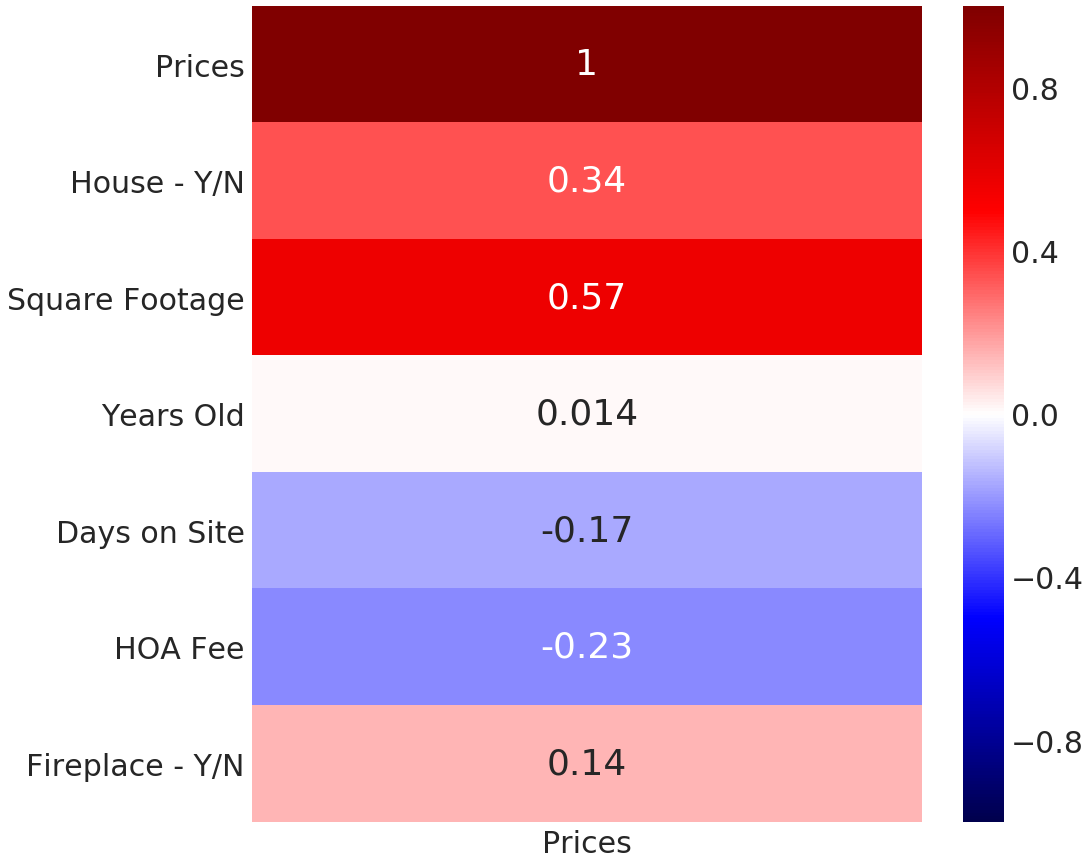

In [35]:
# RUN COUPLE TIMES TO GET THE BEST FONT SIZE

# Show the correlation chart between all features (except School Districts) and Prices
yX_n = yX[['Prices','SingleFamilyResidence','Sq_Ft','Years_Since_Built','Days_On_Site','HOA','Fireplace_b']]
yX_n.columns = ['Prices','House - Y/N','Square Footage','Years Old','Days on Site','HOA Fee','Fireplace - Y/N']
plt.subplots(figsize=(15,15))
sns.set(font_scale = 3)
sns.heatmap(pd.DataFrame(yX_n.corr()['Prices']), cmap="seismic", annot=True, vmin=-1, vmax=1)